# GAIL

## Step 1.生成专家数据

In [1]:
import random

import gym
import torch as th
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm
from torch.nn import functional as F

In [2]:
class PolicyNet(nn.Module):
	def __init__(self, state_dimension, hidden_dimension, action_dimension):
		super(PolicyNet, self).__init__()
		self.fc1 = nn.Linear(state_dimension, hidden_dimension)
		self.fc2 = nn.Linear(hidden_dimension, action_dimension)

	def forward(self, x):
		x = F.relu(self.fc1(x))
		return F.softmax(self.fc2(x), dim=1)

In [3]:
class ValueNet(nn.Module):
	def __init__(self, state_dimension, hidden_dimension):
		super(ValueNet, self).__init__()
		self.fc1 = nn.Linear(state_dimension, hidden_dimension)
		self.fc2 = nn.Linear(hidden_dimension, 1)

	def forward(self, x):
		x = F.relu(self.fc1(x))
		return self.fc2(x)

In [4]:
def compute_advantage(gamma, lambda_, td_delta):
	td_delta = td_delta.cpu().detach().numpy()
	advantage_list = []
	advantage = 0.0
	for delta in td_delta[::-1]:
		advantage = gamma * lambda_ * advantage + delta
		advantage_list.append(advantage)
	advantage_list.reverse()
	return th.tensor(advantage_list, dtype=th.float)

In [5]:
class PPO:
	""" PPO算法，采用截断方式 """

	def __init__(self, state_dimension, hidden_dimension, action_dimension, actor_lr, critic_lr, lambda_, epochs, eps, gamma):
		self.actor = PolicyNet(state_dimension, hidden_dimension, action_dimension).to(device)
		self.critic = ValueNet(state_dimension, hidden_dimension).to(device)
		self.actor_optimizer = th.optim.Adam(self.actor.parameters(), lr=actor_lr)
		self.critic_optimizer = th.optim.Adam(self.critic.parameters(), lr=critic_lr)
		self.gamma = gamma
		self.lambda_ = lambda_
		self.epochs = epochs
		self.eps = eps

	def take_action(self, state):
		state = th.tensor([state], dtype=th.float).to(device)
		probs = self.actor(state)
		action_dist = th.distributions.Categorical(probs)
		action = action_dist.sample()
		return action.item()

	def update(self, transition_dict):
		states = th.tensor(transition_dict["states"], dtype=th.float).to(device)
		actions = th.tensor(transition_dict["actions"], dtype=th.float).view(-1, 1).to(device)
		rewards = th.tensor(transition_dict["rewards"], dtype=th.float).view(-1, 1).to(device)
		next_states = th.tensor(transition_dict["next_states"], dtype=th.float).to(device)
		dones = th.tensor(transition_dict["dones"], dtype=th.float).view(-1, 1).to(device)
		td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones).to(device)
		td_delta = td_target - self.critic(states)
		advantage = compute_advantage(self.gamma, self.lambda_, td_delta).to(device)
		old_log_probs = th.log(self.actor(states).gather(1, actions.type(th.int64))).detach()

		for _ in range(self.epochs):
			log_probs = th.log(self.actor(states).gather(1, actions.type(th.int64)))
			ratio = th.exp(log_probs - old_log_probs)
			surr1 = ratio * advantage
			surr2 = th.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
			actor_loss = th.mean(-th.min(surr1, surr2))
			critic_loss = th.mean(F.mse_loss(self.critic(states), td_target.detach()))
			self.actor_optimizer.zero_grad()
			self.critic_optimizer.zero_grad()
			actor_loss.backward()
			critic_loss.backward()
			self.actor_optimizer.step()
			self.critic_optimizer.step()

In [6]:
def train_on_policy_agent(env, agent, num_episodes, is_render=False):
	return_list = []
	for i in range(epochs):
		with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
			for i_episode in range(int(num_episodes / 10)):
				episode_return = 0
				transition_dict = {"states": [], "actions": [], "next_states": [], "rewards": [], "dones": []}
				state = env.reset()
				done = False
				while not done:
					action = agent.take_action(state)
					next_state, reward, done, _ = env.step(action)

					# 是否渲染动画
					if is_render:
						env.render()

					transition_dict["states"].append(state)
					transition_dict["actions"].append(action)
					transition_dict["next_states"].append(next_state)
					transition_dict["rewards"].append(reward)
					transition_dict["dones"].append(done)
					state = next_state
					episode_return += reward
				return_list.append(episode_return)
				agent.update(transition_dict)
				if (i_episode + 1) % 10 == 0:
					pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
					                  'return': '%.3f' % np.mean(return_list[-10:])})
				pbar.update(1)
	return return_list

In [7]:
class Discriminator(nn.Module):
	def __init__(self, state_dimension, hidden_dimension, action_dimension):
		super(Discriminator, self).__init__()
		self.fc1 = th.nn.Linear(state_dimension + action_dimension, hidden_dimension)
		self.fc2 = th.nn.Linear(hidden_dimension, 1)

	def forward(self, x, a):
		cat_data = th.cat([x, a], dim=1)
		x = F.relu(self.fc1(cat_data))
		return th.sigmoid(self.fc2(x))

In [8]:
class GAIL:
    def __init__(self, agent, state_dimension, action_dimension, hidden_dimension, lr_d):
        self.discriminator = Discriminator(state_dimension, hidden_dimension, action_dimension).to(device)
        self.discriminator_optimizer = th.optim.Adam(self.discriminator.parameters(), lr=lr_d)
        self.agent = agent

    def learn(self, expert_s, expert_a, agent_s, agent_a, next_s, dones):
        expert_states = th.tensor(expert_s, dtype=th.float).to(device)
        expert_actions = th.tensor(expert_a, dtype=th.int64).to(device)
        agent_states = th.tensor(agent_s, dtype=th.float).to(device)
        agent_actions = th.tensor(agent_a, dtype=th.int64).to(device)
        expert_actions = F.one_hot(expert_actions, num_classes=3).float()
        agent_actions = F.one_hot(agent_actions, num_classes=3).float()

        expert_prob = self.discriminator(expert_states, expert_actions)
        agent_prob = self.discriminator(agent_states, agent_actions)
        discriminator_loss = nn.BCELoss()(agent_prob, th.ones_like(agent_prob)) + nn.BCELoss()(expert_prob, th.zeros_like(expert_prob))
        self.discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        self.discriminator_optimizer.step()

        rewards = -th.log(agent_prob).detach().cpu().numpy()
        transition_dict = {
            'states': agent_s,
            'actions': agent_a,
            'rewards': rewards,
            'next_states': next_s,
            'dones': dones
        }
        self.agent.update(transition_dict)

In [9]:
device = th.device("cuda") if th.cuda.is_available() else th.device("cpu")
# device = th.device("cpu")
print(f"device: {device}")

device: cuda


In [10]:
def sample_expert_data(n_episode):
    states = []
    actions = []
    for episode in range(n_episode):
        state = env.reset()
        done = False
        while not done:
            action = ppo_agent.take_action(state)
            states.append(state)
            actions.append(action)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            env.render()
    env.close()
    return np.array(states), np.array(actions)

# Acrobot-v1

In [19]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.999
lambda_ = 0.99
epochs = 20
eps = 0.2

env = gym.make("Acrobot-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
ppo_agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lambda_, epochs, eps, gamma)

In [20]:
print(f"state_dim: {state_dim}\naction_dim: {action_dim}")

state_dim: 6
action_dim: 3


In [21]:
return_list = train_on_policy_agent(env, ppo_agent, num_episodes, is_render=False)

Iteration 19: 100%|██████████| 50/50 [00:11<00:00,  4.48it/s, episode=1000, return=-95.100]


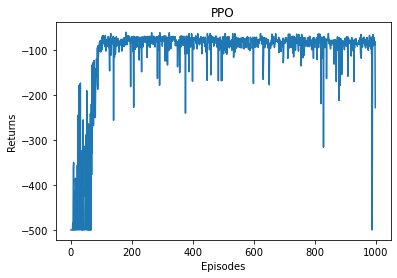

In [22]:
iteration_list = list(range(len(return_list)))
plt.plot(iteration_list, return_list)
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.title("PPO")
plt.show()

In [23]:
n_episode = 100
expert_s, expert_a = sample_expert_data(n_episode)

n_samples = 5000  # 采样100个数据
random_index = random.sample(range(expert_s.shape[0]), n_samples)
expert_s = expert_s[random_index]
expert_a = expert_a[random_index]

In [24]:
print(f"expert_s.shape: {expert_s.shape}\nexpert_a.shape: {expert_a.shape}")

expert_s.shape: (5000, 6)
expert_a.shape: (5000,)


In [33]:
import pandas as pd

In [34]:
expert_a_df = pd.DataFrame(expert_a)

In [43]:
sum(expert_a == 0)

3135

In [44]:
sum(expert_a == 1)

0

In [45]:
sum(expert_a == 2)

1865

In [39]:
expert_a_df.describe()

,0
count,5000.000000
mean,0.746000
std,0.967301
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,2.000000


(array([3135.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1865.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

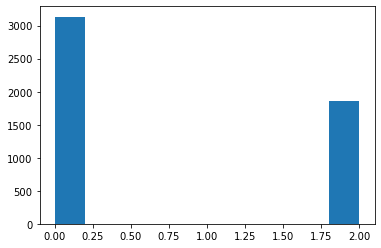

In [38]:
plt.hist(expert_a)

In [30]:
env = gym.make("Acrobot-v1")
lr_d = 1e-3
agent = PPO(state_dim, hidden_dim, action_dim - 1, actor_lr, critic_lr, lambda_, epochs, eps, gamma)
gail = GAIL(agent, state_dim, action_dim, hidden_dim, lr_d)
n_episode = 500
return_list = []

with tqdm(total=n_episode, desc="进度条") as pbar:
    for i in range(n_episode):
        episode_return = 0
        state = env.reset()
        done = False
        state_list = []
        action_list = []
        next_state_list = []
        done_list = []
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, _ = env.step(action)
            state_list.append(state)
            action_list.append(action)
            next_state_list.append(next_state)
            done_list.append(done)
            state = next_state
            episode_return += reward
            env.render()
        return_list.append(episode_return)
        gail.learn(expert_s, expert_a, state_list, action_list, next_state_list, done_list)
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)
    env.close()

D:\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
进度条:   0%|          | 1/500 [01:01<8:28:44, 61.17s/it]


KeyboardInterrupt: 

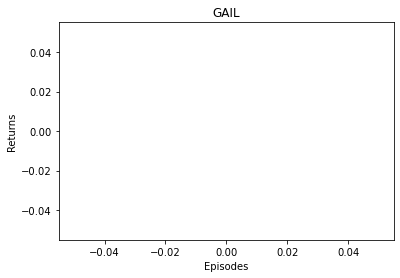

In [29]:
iteration_list = list(range(len(return_list)))
plt.plot(iteration_list, return_list)
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.title("GAIL")
plt.show()